In [ ]:
# Only for Google Collab

# Set the runtime session to a GPU/TPU session first!
# Clone the repository
!git clone https://github.com/RobvanGastel/meta-in-context-learning.git

# Change directory to the cloned repository
%cd meta-in-context-learning

# Potentially this is the only dependency not supported yet
!pip install einops

### Outline of GPICL
Dataset $D = \{x_i, y_i\}$, linear projection $A \in \mathcal{R}^{N_x \times N_x}$ with $A_{ij} \sim N(0, 1/N_x)$ and final output permutation $\rho$ , $D = \{Ax_i, \rho(y_i)\}$.

this is done to reduce the amount of unique tasks necessary to train our meta-learned model. The loss used is cross-entropy loss, between the label $y_j$ and prediction on the entire series except for the last label. Essentially the same the other notebook leaving out only the last label and adding the set of samples as context.

In [20]:
import pickle

import jax
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import serialization
from flax.training import train_state
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from meta_icl.vision_transformer import ViT
from meta_icl.data import FewShotDataset, FewShotBatchSampler

# Parameters
num_epochs = 50
n_way, k_shot = 3, 2
batch_size = 512
seq_length = 6 
seed = 42

v = ViT(
    image_size = 28,
    patch_size = (14, 14),
    num_classes = 10,
    emb_dim = 256,
    seq_length = seq_length,
    channels = 1,
    num_layers = 4,
    num_heads = 8,
    mlp_dim = 512
)

key = jax.random.key(0)
key, x_key, y_key, rng_key = jax.random.split(key, 4)

init_rngs = {'params': rng_key}
X = jax.random.normal(x_key, (batch_size, seq_length, 28*28))
y = jax.random.normal(y_key, (batch_size, seq_length-1))

# TODO: Option to load in trained models
# with open("params.pkl", "rb") as f:
#     state_dict = pickle.loads(f.read())
# params = serialization.from_state_dict(params, state_dict)

params = v.init(init_rngs, X, y)
output = v.apply(params, X, y, rngs=init_rngs)

class TrainState(train_state.TrainState):
    pass

state = TrainState.create(
    apply_fn=v.apply,
    params=params,
    tx=optax.adamw(learning_rate=1e-4)
)

Initializing the functions for the training loop, like GPICL we will augment the few-shot learning tasks in each batch with a linear project $A$ and a permutation function for the classes $\rho(y)$.

In [ ]:
@jax.jit
def augment_tasks(X, y, key):
    batch_size, seq, _, _ = X.shape

    # Linear projection A, A_ij \in N(0, 1/Nx)
    X_bar = jnp.reshape(X, (batch_size, seq, 28*28))
    A = jax.random.normal(key, (batch_size, 28*28), dtype=jnp.float32) / 28
    # X: (batch_size, seq_length, 28*28)
    X_bar = jnp.einsum('bsd,bd->bsd', X_bar, A)

    # Should have permutation \rho(y), to create a new mapping
    perm  = jax.random.permutation(key, 10) # num_classes
    y_bar = perm[y]
    return X_bar, y_bar

Since we are working in JAX we can speed-up our methods with jax.jit when applicable.

In [ ]:
def train_step(state, X, y, train_key, eval_key):
    def loss_fn(params, X, y):
        logits = state.apply_fn(params, X, y[:, :-1])
        # Compare against the last y label in the few-shot task and omit this y label during
        # the forward pass.
        y_one_hot = jax.nn.one_hot(y, 10)[:, -1].squeeze()
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_one_hot))
        return loss

    # Task augmentation
    X_bar, y_bar = augment_tasks(X, y, train_key)

    loss_grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = loss_grad_fn(state.params, X_bar, y_bar)
    state = state.apply_gradients(grads=grads)

    # Validating the performance with a different evaluation key
    X_bar, y_bar = augment_tasks(X, y, eval_key)
    logits = state.apply_fn(state.params, X_bar, y[:, :-1])
    y_one_hot = jax.nn.one_hot(y, 10)[:, -1].squeeze()
    acc = jnp.sum(y[:, -1] == jnp.argmax(logits, axis=-1))
    return state, loss, acc

The training loop for our GPICL model:

In [ ]:
train_dataset = FewShotDataset(dataset=MNIST, train=True)
data_loader = DataLoader(train_dataset, batch_sampler=FewShotBatchSampler(
    train_dataset.y, n_way, k_shot, batch_size=batch_size
    )
)

# Meta-training loop
losses, accuracies = [], []
for epoch in range(num_epochs):
    cumulative_loss = 0
    accuracy = 0.0

    for X, y in data_loader:
        key, train_key, eval_key = jax.random.split(key, 3)
        state, loss, acc = train_step(state, X.numpy(), y.numpy(), train_key, eval_key)
        cumulative_loss += loss.mean()
        accuracy += (acc / batch_size)
        
    losses.append(float(cumulative_loss))
    accuracies.append(float(accuracy))

    if epoch % 5 == 0:
        print(f"epoch {epoch}/{num_epochs}: loss: {cumulative_loss}, accuracy: {accuracy}")

        # Save the weights
        with open(f"output/gpicl_e{epoch}.pkl", "wb") as f:
            f.write(pickle.dumps(serialization.to_state_dict(params)))

epoch 0/50: loss: 8.454620361328125, accuracy: 0.287109375


Plotting the training loss and accuracy during training.

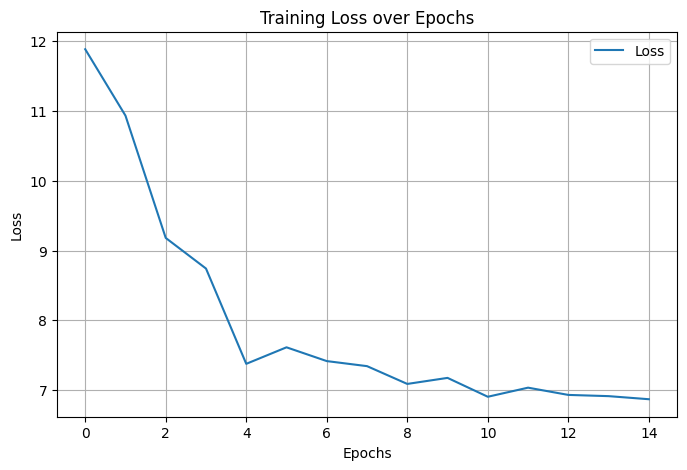

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(losses)), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

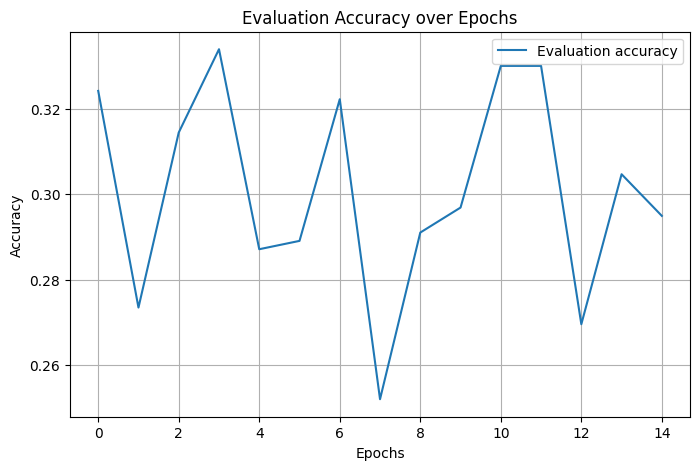

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(accuracies)), accuracies, label='Evaluation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

Inspecting a single batch from the validation loader, for a true evaluation.

_TODO: Test no permutation versus 100% permutation, also check their plateau, memorize or generalize table_

_TODO: Test evaluation on the validation set, and out of domain tests as shown in the paper, FashionMNIST_

In [18]:
val_dataset = FewShotDataset(dataset=MNIST, train=False)
val_data_loader = DataLoader(val_dataset, batch_sampler=FewShotBatchSampler(val_dataset.y, n_way, k_shot))

X, y = next(iter(val_data_loader))

X = X.numpy()
y = y.numpy()

batch_size, seq, _, _ = X.shape
logits = state.apply_fn(state.params, X, y[:, :-1])
jnp.sum(y[:, -1] == jnp.argmax(logits, axis=-1))

Array(0, dtype=int32)

In [19]:
jnp.argmax(logits, axis=-1), y[:, -1]

(Array([7, 7, 7, 0, 7], dtype=int32), array([0, 1, 4, 2, 9]))